In [4]:
import torch
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
from collections import Counter
import ipywidgets as widgets
import json
import csv
import pandas as pd
from urllib.request import urlopen


In [6]:
# Extract projects
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv"
projects = pd.read_csv(url, sep=',') # use sep="," for coma separation.
print (f"{len(projects)} projects")
projects.head()


955 projects


,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


In [7]:
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv"
projects_tags = pd.read_csv(url, sep=',') # use sep="," for coma separation.
print (f"{len(projects_tags)} projects")
projects_tags.head()

955 projects


,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


In [8]:
df = pd.concat([projects, projects_tags], axis=1)
df = df.T.drop_duplicates().T
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [9]:
# Remove projects with no tag
df = df[df.tag.notnull()]

In [10]:
df.to_csv("labeled_projects.csv", index=False)

In [11]:
# Most common tags
tags = Counter(df.tag.values)
tags.most_common()

[('natural-language-processing', 388),
 ('computer-vision', 356),
 ('mlops', 79),
 ('reinforcement-learning', 56),
 ('graph-learning', 45),
 ('time-series', 31)]

In [12]:
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv"
tags_dict = {}
projects_tags = pd.read_csv(url, sep=',') # use sep="," for coma separation
for item in projects_tags.tag:
    tags_dict[item] = item

print (f"{len(tags_dict)} tags")

6 tags


In [13]:
tags_dict

{'computer-vision': 'computer-vision',
 'graph-learning': 'graph-learning',
 'reinforcement-learning': 'reinforcement-learning',
 'natural-language-processing': 'natural-language-processing',
 'mlops': 'mlops',
 'time-series': 'time-series'}

# Exploration(EDA)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

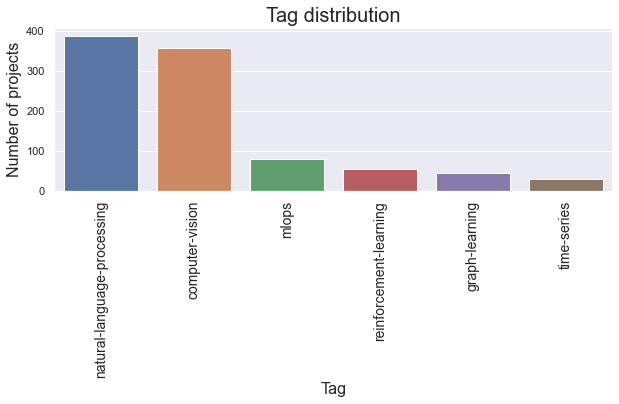

In [15]:
# Distribution of tags
tags, tag_counts = zip(*Counter(df.tag.values).most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

In [16]:
# Wordcloud representation
def display_word_cloud(tag:"natural-language-processing"):
    plt.figure(figsize=(15,5))
    subset = df[df.tag == tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

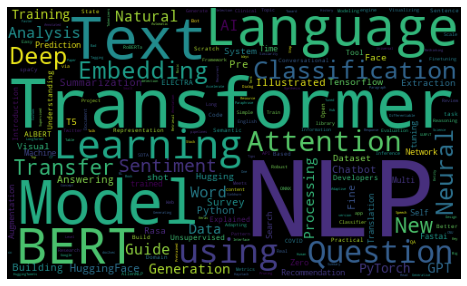

In [17]:
display_word_cloud("natural-language-processing")

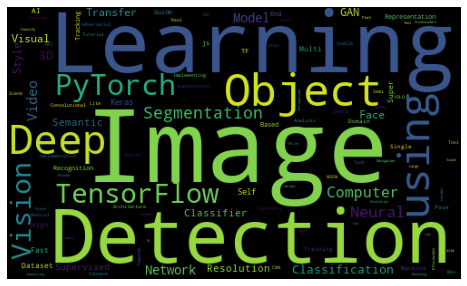

In [18]:
display_word_cloud("computer-vision")

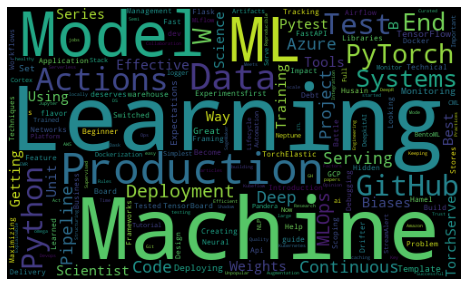

In [19]:
display_word_cloud("mlops")

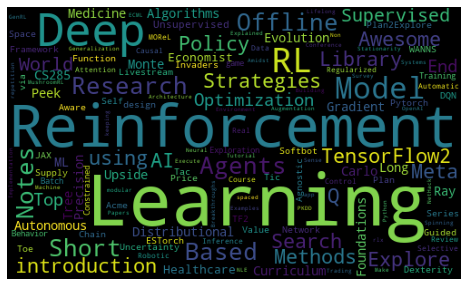

In [20]:
display_word_cloud("reinforcement-learning")

# Labelling

In [21]:
# Min frequency
min_freq = 75
tags = Counter(df.tag.values)

In [22]:
# Tags that just made / missed the cut
@widgets.interact(min_freq=(0, tags.most_common()[0][1]))
def separate_tags_by_freq(min_freq=min_freq):
    tags_above_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] >= min_freq)
    tags_below_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] < min_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(3))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-3:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(3))

interactive(children=(IntSlider(value=75, description='min_freq', max=388), Output()), _dom_classes=('widget-i…

In [23]:
tags_above_freq = Counter(tag for tag in tags.elements() 
                          if (tags[tag] >= min_freq))
df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)

In [24]:
# Fill None with other
df.tag = df.tag.fillna("other")

In [25]:
# Now we have tags with values Computer Vision, NLP, mlops, others
df.head(10)

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other
5,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other
6,26,2020-03-07 23:11:58,Graph Wavelet Neural Network,"A PyTorch implementation of ""Graph Wavelet Neu...",other
7,27,2020-03-07 23:18:15,APPNP and PPNP,"A PyTorch implementation of ""Predict then Prop...",other
8,28,2020-03-07 23:23:46,Attributed Social Network Embedding,A sparsity aware and memory efficient implemen...,other
9,29,2020-03-07 23:45:38,Signed Graph Convolutional Network,"A PyTorch implementation of ""Signed Graph Conv...",other


# Preprocessing

In [26]:
# Feature Engineering
df["text"] = df.title + " " + df.description 

In [27]:
df.head(5)

,id,created_on,title,description,tag,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,Awesome Monte Carlo Tree Search A curated list...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,other,Diffusion to Vector Reference implementation o...


In [28]:
! pip install nltk==3.7 -q

In [29]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [30]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\agarw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text."""
    # Lower
    if lower: 
        text = text.lower()

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

In [32]:
# Toggle preprocessing parameters
@widgets.interact(lower=True, stem=False)
def display_cleaned_text(lower, stem):
    text = "Conditional image generation using Variational Autoencoders and GANs."
    cleaned_text = clean_text(text=text, lower=lower, stem=stem)
    print (cleaned_text)

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Ou…

In [33]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


# Encoding

In [34]:
import numpy as np
import random

In [35]:
# Get data
X = df.text.to_numpy()
y = df.tag

In [36]:
class LabelEncoder(object):
    """Encode labels into unique indices."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [37]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [38]:
label_encoder.class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [39]:
label_encoder.index_to_class

{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [40]:
# Tesing the encoded domain
label_encoder.encode(["computer-vision", "mlops", "mlops"])

array([0, 1, 1])

In [41]:
# Tesing the decoded domain
label_encoder.decode([0, 1, 2])

['computer-vision', 'mlops', 'natural-language-processing']

In [42]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(955,)


In [43]:
X

array(['comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes',
       'show infer tell contextual inference creative captioning beauty work lies way architects fundamental idea humans look overall image individual pieces',
       'awesome graph classification collection important graph embedding classification representation learning papers implementations',
       'awesome monte carlo tree search curated list monte carlo tree search papers implementations',
       'diffusion vector reference implementation diffusion2vec complenet 2018 built gensim networkx',
       'attentionwalk pytorch implementation watch step learning node embeddings via graph attention neurips 2018',
       'graph wavelet neural network pytorch implementation graph wavelet neural network iclr 2019',
       'appnp ppnp pytorch implementation predict propagate graph neural networks meet personalized pagerank iclr 2019',
       'attributed social netwo

In [44]:
y

array([0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3,
       2, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2, 0, 0, 0,
       0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 2, 3, 0, 3, 0, 0, 1, 2, 2, 0, 2, 2,
       0, 3, 2, 0, 2, 0, 0, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 0, 3, 3, 2, 3, 3, 0, 2, 0, 0, 3, 3, 2, 2,
       2, 2, 2, 3, 0, 2, 0, 0, 0, 2, 3, 2, 2, 1, 1, 2, 2, 2, 2, 0, 2, 3,
       3, 3, 2, 0, 2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 2, 2, 0, 2, 3, 2, 0, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 3, 0, 3, 2, 0, 0, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2,
       0, 2, 0, 1, 2, 3, 1, 2, 0, 2, 2, 2, 3, 0, 0, 0, 2, 0, 2, 2, 2, 3,
       3, 3, 2, 0, 3, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 3, 3, 2, 2, 2, 3,
       0, 3, 2, 2, 2, 0, 2, 3, 0, 3, 3, 2, 2, 0, 3, 3, 2, 0, 0, 3, 0, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0,

# Splitting the dataset into Train, Val and Test 

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [47]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

In [48]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 668 (0.70)
remaining: 287 (0.30)


In [49]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)

In [50]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [51]:

# Get counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}

In [52]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,53,12,58,20
test,54,12,58,20


In [53]:
X_train

array(['huggingface nlp library nlp lightweight extensible library easily share load dataset evaluation metrics already providing access 100 datasets 10 evaluatio',
       'docker help become effective data scientist look docker perspective data scientist',
       'survey deep learning localization mapping towards age spatial machine intelligence',
       'ai economist improving equality productivity ai driven tax policies',
       'cvpr 2020 snapshot snapshot conference summarizing papers listing grabbed attention',
       'tracking objects points simultaneous object detection tracking using center points',
       'predicting unintentional action video introduce dataset wild videos unintentional action well suite tasks recognizing localizing anticipating onset',
       'exploration strategies deep reinforcement learning exploitation versus exploration critical topic reinforcement learning post introduces several common approaches better exploration deep rl',
       'ai basketball anal

In [54]:
y_train

array([2, 1, 0, 3, 0, 0, 0, 3, 0, 0, 1, 2, 3, 2, 2, 2, 2, 0, 0, 0, 2, 0,
       2, 3, 2, 2, 2, 3, 2, 2, 2, 0, 1, 0, 3, 3, 2, 3, 0, 2, 0, 3, 1, 2,
       0, 0, 3, 2, 2, 2, 2, 3, 3, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2,
       2, 2, 0, 0, 3, 3, 0, 0, 2, 2, 2, 1, 2, 2, 3, 1, 1, 1, 3, 2, 2, 2,
       2, 3, 2, 2, 0, 1, 3, 0, 3, 3, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 3, 2,
       0, 3, 0, 0, 2, 2, 0, 0, 2, 0, 0, 1, 1, 0, 0, 2, 3, 0, 2, 0, 0, 3,
       0, 0, 2, 1, 1, 3, 2, 2, 2, 0, 3, 2, 0, 0, 0, 0, 2, 0, 0, 3, 2, 2,
       3, 0, 2, 2, 2, 2, 0, 3, 2, 2, 2, 1, 3, 0, 0, 2, 1, 2, 3, 0, 3, 3,
       2, 2, 1, 2, 3, 2, 3, 1, 0, 0, 1, 3, 0, 2, 2, 0, 0, 3, 0, 0, 2, 0,
       0, 0, 2, 0, 0, 2, 2, 1, 0, 2, 0, 2, 2, 0, 1, 0, 2, 3, 3, 2, 0, 0,
       3, 1, 3, 2, 0, 3, 2, 2, 0, 3, 0, 2, 2, 3, 2, 2, 0, 1, 1, 2, 2, 2,
       2, 0, 2, 2, 2, 1, 0, 1, 0, 2, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 3, 3,
       0, 0, 0, 2, 2, 2, 3, 0, 0, 3, 0, 2, 2, 0, 2, 0, 3, 2, 0, 2, 0, 2,
       0, 3, 2, 0, 0, 3, 2, 1, 0, 2, 2, 1, 0, 2, 2,

In [55]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

,text,tag
0,huggingface nlp library nlp lightweight extens...,natural-language-processing
1,docker help become effective data scientist lo...,mlops
2,survey deep learning localization mapping towa...,computer-vision
3,ai economist improving equality productivity a...,other
4,cvpr 2020 snapshot snapshot conference summari...,computer-vision


In [56]:
test_df.head()

,text,tag
0,attentron shot text speech exploiting attentio...,natural-language-processing
1,tensorflow js gesture controlled 2048 gesture ...,computer-vision
2,pytorch cnn trainer simple package fine tune c...,computer-vision
3,hloc hierarchical localization toolbox visual ...,computer-vision
4,evolution strategies evolutionary algorithms r...,other


In [57]:
val_df.head()

,text,tag
0,brat rapid annotation tool brat brat rapid ann...,natural-language-processing
1,stellargraph machine learning graphs state art...,other
2,spinenet novel architecture object detection m...,computer-vision
3,bad passwords nist guidelines example project ...,natural-language-processing
4,explainable ml monitoring video covers overvie...,mlops


# Augmentation

In [58]:
! pip install nlpaug==1.1.0 transformers==3.0.2 -q
! pip install snorkel==0.9.8 -q

In [59]:
import nlpaug.augmenter.word as naw

In [60]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")

In [61]:
text = "Conditional image generation using Variational Autoencoders and GANs."
print(text)
print("*"*50)
for idx in range(10):
    print(substitution.augment(text))

Conditional image generation using Variational Autoencoders and GANs.
**************************************************
perform image generation using digital models and sensors.
conditional image analysis produces variational sequences and filters.
differential image generation affects scan sequences and gans.
soil yield generation using variational analysis using gans.
conditional likelihood stabilization using variational approaches and filtering.
binary packet generation enables variational autoencoders or gans.
fluid flow generation using variational autoencoders or lasers.
conditional image filters using fourier capture and filtering.
digital image compression using variational autoencoders using processors.
supports frame generation using dedicated autoencoders and processors.


In [62]:
text = "Conditional image generation using Variational Autoencoders and GANs."
print(text)
print("*"*50)
for idx in range(10):
    print(insertion.augment(text))

Conditional image generation using Variational Autoencoders and GANs.
**************************************************
conduct conditional image filter generation using periodic variational autoencoders loops and gans.
conditional image signal generation using variational interference autoencoders lasers and quantum gans.
• conditional image capture generation using constant variational autoencoders and logical gans.
enable conditional dynamic image generation using dynamic variational 3d autoencoders and gans.
implementing conditional image sequence generation algorithm using variational autoencoders and computer gans.
conditional image video generation operations using variational binary autoencoders lasers and gans.
conditional network image generation using linear variational autoencoders constraints and differential gans.
conditional image sequence generation operations using partial variational autoencoders and dot gans.
conditional image generation approaches using advanced va

We can use aliases to transform the text, using snorkel's transformation function.

In [63]:
def replace_dash(x):
    return x.replace("-", " ")

In [64]:
# Aliases
aliases_by_tag = {
    "computer-vision": ["cv", "vision"],
    "mlops": ["production"],
    "natural-language-processing": ["nlp", "nlproc"]
}

In [65]:
# Flatten dict
flattened_aliases = {}
for tag, aliases in aliases_by_tag.items():
    tag = replace_dash(x=tag)
    if len(aliases):
        flattened_aliases[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flattened_aliases[alias] = _aliases

In [66]:
print(flattened_aliases)

{'computer vision': ['cv', 'vision'], 'cv': ['vision', 'computer vision'], 'vision': ['cv', 'computer vision'], 'mlops': ['production'], 'production': ['mlops'], 'natural language processing': ['nlp', 'nlproc'], 'nlp': ['nlproc', 'natural language processing'], 'nlproc': ['nlp', 'natural language processing']}


In [67]:
# \b matches spaces
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

In [68]:
from snorkel.augmentation import transformation_function

In [69]:
@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases.""" 
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)  
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(flattened_aliases[tag])}{x.text[match.end():]}"
    return x

In [70]:
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

survey reinforcement learning nlproc tasks
survey reinforcement learning nlproc tasks
survey reinforcement learning natural language processing tasks


In [71]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

autogenerate cv apply jobs using natural language processing
autogenerate cv apply jobs using natural language processing
autogenerate cv apply jobs using nlproc


In [72]:
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier

In [73]:
# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|██████████| 668/668 [00:02<00:00, 253.81it/s]


,text,tag
0,huggingface nlp library nlp lightweight extens...,natural-language-processing
0,huggingface natural language processing librar...,natural-language-processing
0,huggingface nlproc library nlp lightweight ext...,natural-language-processing
1,docker help become effective data scientist lo...,mlops
2,survey deep learning localization mapping towa...,computer-vision


In [74]:

len(train_df), len(train_df_augmented)

(668, 913)

# Modeling

We will start with a very basic model and then we will try to enhance the model for our use case

In [75]:
import random
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)

In [76]:
# Accepted tags (external constraint)
ACCEPTED_TAGS = ["natural-language-processing", "computer-vision", "mlops", "graph-learning"]

In [77]:
def preprocess(df, lower, stem, min_freq):
    df["text"] = df.title  + " " + df.description
    df.text = df.text.apply(clean_text, lower=lower,stem=stem)

    oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
    print(oos_tags)
    df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)

    # Replace tags below min_freq with `other`
    tags = Counter(df.tag.values)
    tags_above_freq = Counter(tag for tag in tags.elements() 
                            if (tags[tag] >= min_freq))
    df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)
    df.tag = df.tag.fillna("other")

    return df




In [78]:
def get_data_splits(X, y, train_size=0.7):
    """Generate balanced data splits."""
    X_train, X_, y_train, y_ = train_test_split(
        X, y, train_size=train_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(
        X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Baseline Model

In [79]:
from sklearn.metrics import precision_recall_fscore_support

In [80]:
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True,stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

['time-series', 'reinforcement-learning']


In [81]:
X_train

array(['laplacian pyramid reconstruction refinement semantic seg pytorch implementation multi resolution reconstruction architecture based laplacian pyramid uses skip connections',
       'extract stock sentiment news headlines project generate investing insight applying sentiment analysis financial news headlines finviz',
       'big bad nlp database collection 400 nlp datasets papers included',
       'job classification job classification done using techniques nlp ml dataset used kaggle indeeed job posting',
       'optimizing mobiledet mobile deployments learn criticalities effectively optimizing mobiledet object detectors mobile deployments',
       'multimodal meme classification uniter given state art results various image text related problems project aims finetuning uniter solve hateful memes challenge',
       'gans computer vision article review series article series review important research papers gans 2015 today 6 articles 20 papers 20000 words',
       'almost everything

In [82]:
y_train

array([0, 2, 2, 2, 0, 0, 0, 3, 1, 2, 2, 2, 2, 3, 2, 0, 0, 1, 2, 3, 0, 3,
       0, 2, 0, 0, 0, 0, 0, 3, 3, 2, 0, 0, 1, 0, 2, 2, 2, 0, 0, 2, 2, 0,
       0, 3, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 3, 3, 0, 3, 2, 2, 0, 2,
       0, 2, 1, 2, 3, 2, 0, 0, 2, 2, 2, 3, 0, 0, 2, 3, 0, 1, 1, 2, 1, 1,
       2, 2, 3, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0, 2, 3, 0, 2, 3,
       3, 0, 0, 2, 2, 2, 2, 0, 2, 3, 3, 2, 1, 3, 3, 0, 2, 2, 0, 0, 0, 2,
       0, 1, 0, 3, 0, 0, 0, 3, 3, 3, 0, 1, 0, 0, 0, 0, 2, 0, 3, 0, 0, 3,
       0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2,
       2, 2, 0, 2, 2, 3, 3, 2, 0, 2, 0, 2, 3, 2, 1, 0, 0, 0, 0, 2, 0, 2,
       2, 3, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 1, 2,
       0, 0, 0, 2, 0, 0, 0, 2, 3, 2, 3, 2, 2, 2, 0, 3, 2, 3, 0, 2, 2, 2,
       2, 0, 2, 3, 0, 3, 2, 2, 3, 2, 0, 2, 0, 0, 0, 2, 3, 2, 0, 1, 2, 2,
       2, 0, 0, 0, 2, 1, 0, 1, 1, 3, 3, 2, 3, 2, 0, 0, 3, 0, 1, 3, 2, 0,
       0, 3, 2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 0, 0, 2,

In [83]:
# Label encoder
print (label_encoder)
print (label_encoder.classes)

<LabelEncoder(num_classes=4)>
['computer-vision', 'mlops', 'natural-language-processing', 'other']


In [84]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=len(label_encoder), size=len(y_test))
print(y_pred.shape)
print(y_pred)

(144,)
[2 2 1 3 3 3 3 3 1 2 2 1 3 1 2 0 1 3 2 2 2 2 3 0 2 1 0 2 0 1 2 1 3 2 2 2 2
 3 2 0 2 3 2 0 3 3 0 0 0 0 0 3 3 2 2 1 2 2 0 0 2 1 0 2 2 3 1 3 1 0 1 2 2 1
 1 1 3 1 0 3 3 1 0 3 2 3 1 0 1 2 2 2 1 3 1 0 3 2 1 2 2 0 3 0 0 0 2 0 0 3 3
 0 3 3 0 2 0 3 2 1 2 3 2 0 1 1 1 3 3 1 2 1 2 2 3 2 1 3 0 0 3 1 0 0]


In [85]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.2844744487889649,
  "recall": 0.22916666666666666,
  "f1": 0.24552884283001275
}


In [86]:
# Class frequencies
p = [Counter(y_test)[index]/len(y_test) for index in range(len(label_encoder))]
print(p)

[0.375, 0.08333333333333333, 0.4027777777777778, 0.1388888888888889]


# Rule based predictions

In [87]:

# Setup
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

['time-series', 'reinforcement-learning']


# Vectorization

In [88]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
dataset = [
    "I enjoy reading about Machine Learning and Machine Learning is my PhD subject",
    "I would enjoy a walk in the park",
    "I was reading in the library"
]

In [89]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(dataset)
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print(df)

            TF-IDF
machine   0.513720
learning  0.513720
about     0.256860
subject   0.256860
phd       0.256860
and       0.256860
my        0.256860
is        0.256860
reading   0.195349
enjoy     0.195349
library   0.000000
park      0.000000
in        0.000000
the       0.000000
walk      0.000000
was       0.000000
would     0.000000


In [90]:
# Setup
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

['time-series', 'reinforcement-learning']


In [91]:
# Saving raw X_test to compare with later
X_test_raw = X_test

In [92]:
# Tf-idf
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7))  # char n-grams
print (X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print (X_train[0])
print (X_train.shape)  # scipy.sparse.csr_matrix

laplacian pyramid reconstruction refinement semantic seg pytorch implementation multi resolution reconstruction architecture based laplacian pyramid uses skip connections
  (0, 27075)	0.03486417410747293
  (0, 59397)	0.037070483947105486
  (0, 61797)	0.037070483947105486
  (0, 66741)	0.037070483947105486
  (0, 20170)	0.037070483947105486
  (0, 1777)	0.037070483947105486
  (0, 69944)	0.037070483947105486
  (0, 45966)	0.037070483947105486
  (0, 48730)	0.037070483947105486
  (0, 82999)	0.037070483947105486
  (0, 6456)	0.037070483947105486
  (0, 80656)	0.037070483947105486
  (0, 32521)	0.037070483947105486
  (0, 81967)	0.037070483947105486
  (0, 93476)	0.037070483947105486
  (0, 7558)	0.037070483947105486
  (0, 22293)	0.037070483947105486
  (0, 42253)	0.037070483947105486
  (0, 55697)	0.037070483947105486
  (0, 12496)	0.037070483947105486
  (0, 74148)	0.037070483947105486
  (0, 3948)	0.03486417410747293
  (0, 21788)	0.037070483947105486
  (0, 27441)	0.037070483947105486
  (0, 81591)	0.0370

In [93]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [249  55 272  92],
class weights: {0: 0.004016064257028112, 1: 0.01818181818181818, 2: 0.003676470588235294, 3: 0.010869565217391304}


# Data Imbalance

In [94]:
! pip install imbalanced-learn==0.8.1 -q

In [95]:
from imblearn.over_sampling import RandomOverSampler

In [96]:
# Oversample (training set)
oversample = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [104]:
import matplotlib.pylab as plt

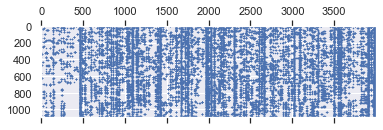

In [116]:
plt.spy(X_over[:,0:4000],markersize=0.5)

In [117]:
# Class weights
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [272 272 272 272],
class weights: {0: 0.003676470588235294, 1: 0.003676470588235294, 2: 0.003676470588235294, 3: 0.003676470588235294}


# Machine Learning
We are going to use SGD with log loss, which is basically logistic loss

In [118]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support

In [129]:
# Initialize model
model = SGDClassifier(
    loss="log", penalty="l2", alpha=1e-4, max_iter=1,
    learning_rate="optimal", eta0=1e-1, power_t=0.1, 
    warm_start=True)

In [130]:
# Train model
num_epochs = 5000
for epoch in range(num_epochs):
    # Training
    model.fit(X_over, y_over)

    # Evaluation
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))

    if not epoch%10:
        print(
            f"Epoch: {epoch:02d} | "
            f"train_loss: {train_loss:.5f}, "
            f"val_loss: {val_loss:.5f}"
        )

Epoch: 00 | train_loss: 0.11955, val_loss: 0.39352
Epoch: 10 | train_loss: 0.12729, val_loss: 0.39979
Epoch: 20 | train_loss: 0.13136, val_loss: 0.40528
Epoch: 30 | train_loss: 0.11678, val_loss: 0.39472
Epoch: 40 | train_loss: 0.12449, val_loss: 0.40239
Epoch: 50 | train_loss: 0.12360, val_loss: 0.39459
Epoch: 60 | train_loss: 0.11984, val_loss: 0.38477
Epoch: 70 | train_loss: 0.11717, val_loss: 0.40540
Epoch: 80 | train_loss: 0.12268, val_loss: 0.40052
Epoch: 90 | train_loss: 0.12102, val_loss: 0.39505
Epoch: 100 | train_loss: 0.11775, val_loss: 0.39330
Epoch: 110 | train_loss: 0.12297, val_loss: 0.39830
Epoch: 120 | train_loss: 0.12538, val_loss: 0.40534
Epoch: 130 | train_loss: 0.11834, val_loss: 0.39687
Epoch: 140 | train_loss: 0.12158, val_loss: 0.39919
Epoch: 150 | train_loss: 0.12713, val_loss: 0.38928
Epoch: 160 | train_loss: 0.11857, val_loss: 0.39145
Epoch: 170 | train_loss: 0.12265, val_loss: 0.39262
Epoch: 180 | train_loss: 0.12959, val_loss: 0.40395
Epoch: 190 | train_los